# POS Tagging

Build a multiclass classifier to predict the POS tag of each word. Use a sliding window, i.e. represent each word by the concatenation of the embeddings of 5 words, i.e. the word, two preceding and two following words. Add a special padding word to the embeddings to represent words close to the beginning or end of a sentence.

Get the Brown corpus.

In [1]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Get the tokenized and tagged with Universal POS sentences from the "news" category from the Brown corpus:

In [2]:
from nltk.corpus import brown
nltk.download('universal_tagset')
brown_sents = brown.tagged_sents(categories='news', tagset='universal')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


See an example

In [3]:
brown_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

## Split into train and test
Use all but the last 1000 sentences to train the classifier. (It should be better to choose them randomly).

In [4]:
brown_train = brown_sents[:-1000]
brown_test = brown_sents[-1000:]

## Build dictionary of words and tags

Vocabularies of words and tags:

In [5]:
word_set = set()
tag_set = set()
for sentence in brown_sents:
    for word, tag in sentence:
        word_set.add(word)
        tag_set.add(tag)

Dictionaries of words and tags:

In [6]:
word_index = {word: idx + 2 for idx, word in enumerate(word_set)} # + 2 leave 0 and 1 for padding and unknown
    
tag_index = {tag: idx for idx,tag in enumerate(tag_set)}
int2tag = list(tag_set)

n_words = len(word_index) + 2 # for padding and OOV
n_tags = len(tag_set)

See the tag set of Universal Dependencies:

In [7]:
tag_set

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

## Data representation

We will use a NN classifier for POS tagging.

In order to provide some context for the classifer, we represent each token as an n-gram of 5 tokens, considering 2 tokens on the left and 2 on the right.

In [8]:
import numpy as np

def build_ngrams(sentences, ctx_size, word_index, tag_index):
    """
    Turn sentences into n-grams of word indices, taken from word_index.
    :param setences: a list of sentences.
    :param ctx_size: numer of tokens to consider before and after each word.
    :param word_index: dictionary of words.
    :param tag_index: dictionary of tags.
    :return: the list of n-grams and the list of corresponding labels.
    """
    padding_idx = 0
    unknown_idx = 1
    
    X = []
    Y = []
    
    for sentence in sentences:
        for n, (word, tag) in enumerate(sentence):
            word_indices = []
            for i in range(n - ctx_size, n + ctx_size + 1):
                # add padding
                if i < 0 or i >= len(sentence):
                    word_indices.append(padding_idx)
                    continue
                gram = sentence[i][0]
                # index of either word, lowercase word or unknown
                word_idx = word_index.get(gram) or word_index.get(gram.lower(),unknown_idx)
                word_indices.append(word_idx)

            X.append(word_indices)
            Y.append(tag_index[tag])
            
    return np.asarray(X), np.asarray(Y)                    

## Build the data set of n-grams

In [9]:
ctx_size = 2
window_size = 2 * ctx_size + 1
x_train, y_train = build_ngrams(brown_train, ctx_size, word_index, tag_index)
x_test, y_test = build_ngrams(brown_test, ctx_size, word_index, tag_index)

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((77552, 5), (77552,), (23002, 5), (23002,))

In [11]:
x_train[0]

array([   0,    0, 2504, 5850, 1016])

## NN Classifier

The NN classifier will produce a probability distribution for each tag:

   $P(t_{i,j}|w_{i-2}w_{i-1}w_iw_{i+1}w_{i+2}) = softmax(W\cdot E(w_{i-2})...E(w_{i+2}))$

where $E(w)$ is the embedding for word $w$.

The predicted output will be the tag with the highest probability, i.e.:

   $y_i = argmax_{j}P(t_{i,j}|w_{i-2}...w_{i+2})$

The output of the classifier should be a vector of size as the number of possible tags.
We can obtain this using function `to_categorical`, to turn tag indices into a one-hot representation:

In [12]:
from keras.utils import to_categorical
to_categorical?

Convert tags into one-hot representation:

In [13]:
y_train_cat = to_categorical(y_train, num_classes=n_tags)
y_test_cat = to_categorical(y_test, num_classes=n_tags)

In [14]:
x_train.shape, y_train_cat.shape, x_test.shape, y_test_cat.shape

((77552, 5), (77552, 12), (23002, 5), (23002, 12))

See one result in categorical form:

In [15]:
y_train[0], y_train_cat[0]

(11, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

### Build the model

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten
from keras.layers import Dropout, Dense
from keras.losses import categorical_crossentropy

Hyperparameters

In [17]:
MAX_SEQUENCE_LENGTH = 250
HIDDEN_SIZE = 128
EMBEDDING_DIM = 50
EPOCHS = 4
BATCH_SIZE = 64

In [18]:
model = Sequential()
model.add(Embedding(n_words, EMBEDDING_DIM, input_length=window_size))
model.add(Flatten())
model.add(Dropout(0.2)) # optional
model.add(Dense(HIDDEN_SIZE, activation='relu'))
model.add(Dropout(0.2)) # optional
model.add(Dense(n_tags, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

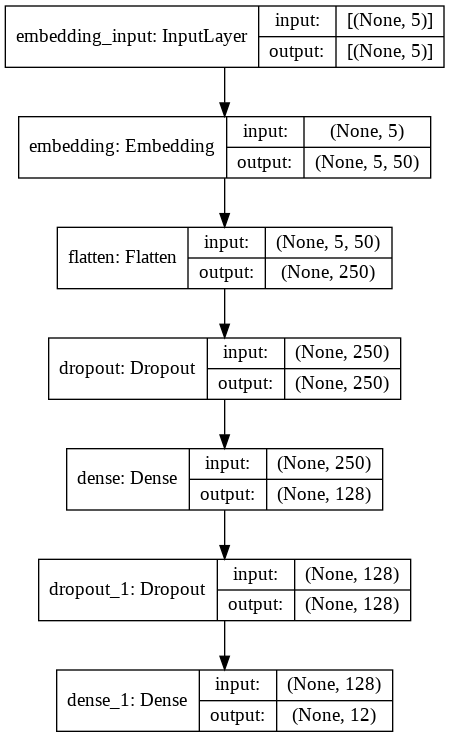

In [19]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

### Train the model

In [20]:
history = model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
1212/1212 [==============================] - 12s 9ms/step - loss: 1.0030 - accuracy: 0.7106
Epoch 2/4
1212/1212 [==============================] - 11s 9ms/step - loss: 0.0980 - accuracy: 0.9709
Epoch 3/4
1212/1212 [==============================] - 11s 9ms/step - loss: 0.0409 - accuracy: 0.9880
Epoch 4/4
1212/1212 [==============================] - 11s 9ms/step - loss: 0.0227 - accuracy: 0.9932


### Evaluate the tagger
`predict_classes` returns the `argmax` of the predicted `softmax` scores.

In [21]:
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


This is equivalent of calling `predict` to obtain a probability distribution and then taking the `argmax`:

In [22]:
y_pred_cat = model.predict(x_test)
y_pred == y_pred_cat.argmax(1)

array([ True,  True,  True, ...,  True,  True,  True])

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_micro_avg(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred) * 100
    pr = precision_score(y_test, y_pred, average='micro') * 100
    rc = recall_score(y_test, y_pred, average='micro') * 100
    f1 = f1_score(y_test, y_pred, average='micro') * 100
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f, F1: %.2f" %
          (acc, pr, rc, f1))

In [24]:
show_micro_avg(y_test, y_pred)

Accuracy: 93.24, Precision: 93.24, Recall: 93.24, F1: 93.24


### Show the confusion matrix

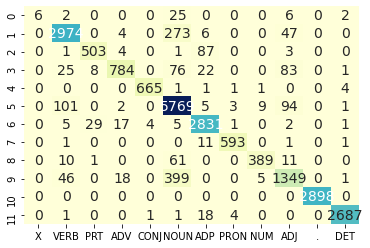

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

import seaborn as sn
import pandas as pd
%matplotlib inline

df = pd.DataFrame(cm, columns=tag_set)
sn.heatmap(df, annot=True, cbar=False, fmt="d", cmap="YlGnBu", annot_kws={"size": 14})# font size

## POS Tagger with Conv1D
Instead of creating the ngrams explicitly, one could use a `Conv1D` layer to group tokens. 

In [26]:
unknown_idx = 1
x_train = [[word_index.get(word.lower(), unknown_idx)
            for word,tag in sentence] for sentence in brown_train]
y_train = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_train]
x_test = [[word_index.get(word.lower(), unknown_idx)
                    for word,tag in sentence] for sentence in brown_test]
y_test = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_test]

In [27]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_train = pad_sequences(y_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_test = pad_sequences(y_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [28]:
y_train_cat = to_categorical(y_train, num_classes=n_tags)
y_test_cat = to_categorical(y_test, num_classes=n_tags)

### Build the model

In [29]:
filters = 16

from keras.layers import Conv1D, MaxPooling1D

model = Sequential()
model.add(Embedding(n_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters, window_size, padding='same', activation='relu'))
#model.add(MaxPooling1D(window_size))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_tags, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

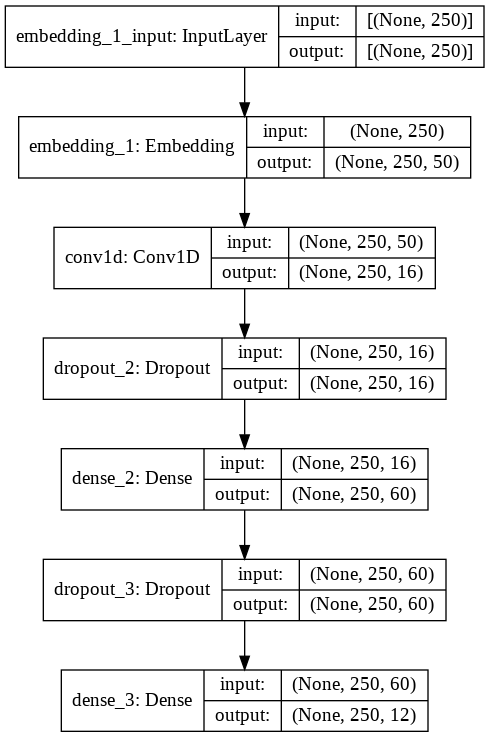

In [30]:
plot_model(model, show_shapes=True)

In [31]:
history = model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
57/57 [==============================] - 5s 68ms/step - loss: 2.1296 - accuracy: 0.7248
Epoch 2/4
57/57 [==============================] - 4s 66ms/step - loss: 0.2117 - accuracy: 0.9425
Epoch 3/4
57/57 [==============================] - 4s 67ms/step - loss: 0.1255 - accuracy: 0.9663
Epoch 4/4
57/57 [==============================] - 4s 66ms/step - loss: 0.0846 - accuracy: 0.9751


In [32]:
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Convert label ids to labels and use them for sklearn's reports

In [33]:
def y2label(gold, pred, pad=0):
    out_true = []
    out_pred = []
    for g, p in zip(gold, pred):
        if g != pad: # Exclude -PAD- term
            out_true.append(int2tag[g])
            out_pred.append(int2tag[p])
    return out_true, out_pred

In [34]:
yl_true, yl_pred = y2label(y_test.flat, y_pred.flat)

# Classification report

In [35]:
from sklearn.metrics import classification_report

In [36]:
print(classification_report(yl_true, yl_pred, digits=4))

              precision    recall  f1-score   support

           .     0.9948    0.9948    0.9948      2898
         ADJ     0.0000    0.0000    0.0000      1818
         ADP     0.8556    0.9765    0.9121      2895
         ADV     0.0000    0.0000    0.0000       999
        CONJ     0.0000    0.0000    0.0000       673
         DET     0.9132    0.9816    0.9462      2712
        NOUN     0.6870    0.9858    0.8097      5984
         NUM     0.0000    0.0000    0.0000       472
        PRON     0.0000    0.0000    0.0000       607
         PRT     0.0000    0.0000    0.0000       599
        VERB     0.5917    0.8584    0.7005      3304
           X     0.0000    0.0000    0.0000         0

    accuracy                         0.7450     22961
   macro avg     0.3369    0.3998    0.3636     22961
weighted avg     0.6055    0.7450    0.6641     22961



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# POS Tagger based on Maximum Entropy Memory Model 

In [37]:
import numpy as np
import re
from nltk.classify.maxent import MaxentClassifier

### The feature extractor
The MaxEnt classifiers relies on hand crafted feature representations for the input words.

The features we use:
<ul>
    <li>morphological aspects of English words, e.g. words ending in 'ed', 'ing', or 'ly'</li>
    <li>capitalization, not at the beginning of a sentence</li>
    <li>presence of the word in a list of closed POS categories, e.g. 'CONJ', 'DET', 'PRON', 'PRT</li>
    <li>aspects of the previos word: e.g capitalization, particle</li>
</ul>
You can think of many such features.

Until a few years ago, the SoTA POS taggers were using a rich feature set. See for example:

Giménez, J., and Márquez, L. 2004. [SVMTool: A general POS tagger generator based on Support Vector Machines](https://www.cs.upc.edu/~nlp/SVMTool/lrec2004-gm.pdf]). Proceedings of LREC'04. Lisbon, Portugal.

Compute the most common suffixes:

In [38]:
suffix_fdist = nltk.FreqDist()
for word in brown.words():
     word = word.lower()
     suffix_fdist[word[-2:]] += 1
     suffix_fdist[word[-3:]] += 1

common_suffixes = [suffix for (suffix, count) in suffix_fdist.most_common(20)]

In [39]:
common_suffixes

[',',
 '.',
 'he',
 'of',
 'the',
 'to',
 'in',
 'a',
 'ed',
 'nd',
 'is',
 'on',
 'and',
 'ng',
 'er',
 'as',
 'ing',
 'at',
 'es',
 'or']

Collects the feature of a word at position n in a sentence

In [40]:
def features_dict(word, prev_word, prev_tag, n, lexicon):
    """
    :param word: the current word
    :param prev_word: the preceding word, or None if it soes not exist
    :param prev_tag: the tag of the previous word
    :param n: the position of the word in the sentence
    :param lexicon: a lexicon of POS for each word
    :return: a dictionary of features {feature: value}
    """
    word = word.lower()
    prev_word = prev_word.lower() if prev_word else ''
    DET = lexicon['DET']
    CONJ = lexicon['CONJ']
    PRON = lexicon['PRON']
    PRT = lexicon['PRT']

    features = {
        'wi': word,
        'wi-1': prev_word,
        'CurCap': is_cap(word),
        'FirstWord': n == 0,
        'HasNumb': has_number(word),
        'Article': word in DET,
        'PrevArticle': prev_word in DET,
        'Conj': word in CONJ,
        'Pron': word in PRON,
        'Prt': word in PRT,
        'PrevConj': prev_word in CONJ,
        'PrevPrt': prev_word in PRT,
        'PrevTag': prev_tag   # required to compute transition probabilities
    }
    for suffix in common_suffixes:
        if word.endswith(suffix):
            features[f'endswith({suffix})'] = 1
    # presence in given POS list
    for tag, words in lexicon.items():
        if word in words:
            features[tag] = 1
    return features

Features

In [41]:
def is_cap(word):
    return word[0].isupper()

def has_number(word):
    return re.search(r'\d+', word) is not None

In [42]:
def create_featuresets(sentence, lexicon):
    """
    Build a featureset for each token in a sentence, for use in training a MaxentClassifier.
    :param sentence: a list of pairs (word, tag).
    :return: a list of pairs (featurset, tag)
    """
    for n, (word, tag) in enumerate(sentence):
        prev_word, prev_tag = sentence[n-1] if n > 0 else (None, None)
        yield (features_dict(word, prev_word, prev_tag, n, lexicon), tag)


Build lexicons for a certain closed classes of POS. We will use the presence in such lexicon as a feature.

In [43]:
from collections import defaultdict

def create_lexicon(trainset, tags=('ADV', 'DET', 'PRON', 'PRT')):
    """
    Build lexicon of words belonging to specific closed categories.
    """
    lexicon = defaultdict(set)
    for sent in trainset:
        for w,t in sent:
            if t in tags:
                lexicon[t].add(w)
    return lexicon

## MaxEntropy Memory Model Tagger

In [89]:
from nltk.classify.maxent import MaxentClassifier

class MemmTagger():
    
    def __init__(self, trainset, max_iter=20):
        """
        :param trainset: list of sentences, each a list of pairs (word, tag)
        """
        self.tags = list(set((tag for sent in trainset for word,tag in sent)))
        self.lexicon = create_lexicon(trainset)
        self.featuresets = [pair for sentence in trainset for pair in create_featuresets(sentence, self.lexicon)]
        self.classifier = MaxentClassifier.train(self.featuresets, max_iter=max_iter)
    
    def tag(self, sentence):
        """
        :param sentence: list of pairs (word, tag)
        """
        tags = self.viterbi(sentence)
        return list(zip(sentence, tags))
    
    def viterbi(self, words):
        """
        Returns the tag sequence of the optimal (most probable) path through
        the MEMM. Uses the Viterbi algorithm to calculate this path by dynamic
        programming.

        :return: the tag sequence
        :rtype: sequence of any
        :param words: the sequence of words
        :type words: list of pairs (word, tag)
        """
        T = len(words)
        N = len(self.tags)

        V = np.zeros((T, N), np.float32)
        B = -np.ones((T, N), np.int)

        featuresets = list(create_featuresets(words, self.lexicon))
        P = [ self.classifier.prob_classify(featureset) for (featureset, label) in featuresets ]
        #return [x.max() for x in P] # DEBUG
        # the forward probability: s1 = previous label, s2 = next label
        # A[t, s2] = Sum{s1} A[t-1, s1] * p(s2| s1,o_t)
        # P[t/s1].prob(s2) = p(s2| s1,o_t)
        # where P[t/s1] is the dist prob at t if previous tag was s1
        # A[t, s2] = sum(A[t-1, s1] * P[t/s1].prob(s2) forall s1)
        A = np.zeros(N)
        for s,i in enumerate(self.tags):
            A[s] = P[0].logprob(i)
                
        V[0] = A
        for t in range(1, T):
            # build transition probabilities
            A1 = np.zeros(N)
            for s,i in enumerate(self.tags):
                Pb = [V[t - 1, s1] + self.prob_from_tag(featuresets[t][0], s1).logprob(i) for s1 in range(N)]
                best = np.argmax(Pb)
                A1[s] = Pb[best]
                B[t, s] = best
                V[t, s] = A1[s]
                #V[t, s] = A1[s] + P[t].logprob(s)

        # backtrace:
        current = np.argmax(V[T - 1, :])
        tags = [current]
        for t in range(T - 1, 0, -1):
            last = B[t, current]
            tags.insert(0, last)
            current = last

        return list(map(self.tags.__getitem__, tags))

                            
    def prob_from_tag(self, featureset, prev_tag):
        """
        Calculate the probability distribution of featureset when the previous tag is :param prev_tag:
        """
        cur_tag = featureset['PrevTag'] # save gold
        featureset['PrevTag'] = self.tags[prev_tag] # predicted
        prob_dist = self.classifier.prob_classify(featureset)
        featureset['PrevTag'] = cur_tag # restore gold
        return prob_dist

## Train the Maximum Entropy Memory Model

<b>Warning</b>: training is quite slow.

In [90]:
tagger = MemmTagger(brown_train, max_iter=20)

  ==> Training (20 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -2.48491        0.001
             2          -1.35686        0.531
             3          -1.09917        0.637
             4          -0.93441        0.731
             5          -0.81685        0.804
             6          -0.72837        0.840
             7          -0.65944        0.857
             8          -0.60426        0.870
             9          -0.55907        0.884
            10          -0.52133        0.894
            11          -0.48927        0.903
            12          -0.46165        0.913
            13          -0.43755        0.919
            14          -0.41630        0.924
            15          -0.39739        0.929
            16          -0.38043        0.936
            17          -0.36510        0.940
            18          -0.35117        0.943
            19          -0.33843        0.946
  

In [91]:
tagger.tag(brown_test[1])

[(('Mollusks', 'NOUN'), 'NOUN'),
 (('are', 'VERB'), 'VERB'),
 (('a', 'DET'), 'DET'),
 (('case', 'NOUN'), 'NOUN'),
 (('in', 'ADP'), 'ADP'),
 (('point', 'NOUN'), 'NOUN'),
 (('.', '.'), '.')]

In [92]:
brown_test[1]

[('Mollusks', 'NOUN'),
 ('are', 'VERB'),
 ('a', 'DET'),
 ('case', 'NOUN'),
 ('in', 'ADP'),
 ('point', 'NOUN'),
 ('.', '.')]

In [93]:
tag_pred = [tagger.tag(sent) for sent in brown_test]

In [94]:
pred_y = [tag for sent in tag_pred for word,tag in sent]

In [95]:
test_y = [tag for sent in brown_test for word,tag in sent]

In [80]:
print(classification_report(test_y, pred_y, digits=4))

              precision    recall  f1-score   support

           .     0.9715    0.8813    0.9242      2898
         ADJ     0.8725    0.5121    0.6454      1818
         ADP     0.9089    0.8653    0.8866      2895
         ADV     0.9117    0.7237    0.8069       999
        CONJ     0.9865    0.8692    0.9242       673
         DET     0.9943    0.9687    0.9813      2712
        NOUN     0.7579    0.9714    0.8515      5984
         NUM     0.9586    0.6377    0.7659       472
        PRON     0.9858    0.9160    0.9496       607
         PRT     0.7570    0.8631    0.8066       599
        VERB     0.8989    0.8938    0.8963      3304
           X     1.0000    0.1463    0.2553        41

    accuracy                         0.8726     23002
   macro avg     0.9170    0.7707    0.8078     23002
weighted avg     0.8849    0.8726    0.8693     23002



In [72]:
print(classification_report(test_y, pred_y, digits=4))

              precision    recall  f1-score   support

           .     0.9676    0.8854    0.9247      2898
         ADJ     0.8750    0.5506    0.6759      1818
         ADP     0.9104    0.9088    0.9096      2895
         ADV     0.9284    0.7267    0.8153       999
        CONJ     0.9900    0.8826    0.9332       673
         DET     0.9924    0.9664    0.9793      2712
        NOUN     0.7708    0.9647    0.8569      5984
         NUM     0.9681    0.6419    0.7720       472
        PRON     0.9806    0.9176    0.9481       607
         PRT     0.8111    0.8815    0.8448       599
        VERB     0.8936    0.8847    0.8891      3304
           X     0.0000    0.0000    0.0000        41

    accuracy                         0.8792     23002
   macro avg     0.8407    0.7676    0.7957     23002
weighted avg     0.8877    0.8792    0.8761     23002



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
print(classification_report(test_y, pred_y, digits=4))

              precision    recall  f1-score   support

           .     0.9676    0.8854    0.9247      2898
         ADJ     0.8750    0.5506    0.6759      1818
         ADP     0.9104    0.9088    0.9096      2895
         ADV     0.9284    0.7267    0.8153       999
        CONJ     0.9900    0.8826    0.9332       673
         DET     0.9924    0.9664    0.9793      2712
        NOUN     0.7708    0.9647    0.8569      5984
         NUM     0.9681    0.6419    0.7720       472
        PRON     0.9806    0.9176    0.9481       607
         PRT     0.8111    0.8815    0.8448       599
        VERB     0.8936    0.8847    0.8891      3304
           X     0.0000    0.0000    0.0000        41

    accuracy                         0.8792     23002
   macro avg     0.8407    0.7676    0.7957     23002
weighted avg     0.8877    0.8792    0.8761     23002



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusions

Draw your conclusions about sequence tagging using either plain NN, NN with embrddings, CNN or Maximum Entropy using hand crafted features.

In [ ]:
# Why the classifer returns always 0?
sent = brown_train[0]
featuresets = create_featuresets(sent, tagger.lexicon)
P = [ tagger.classifier.prob_classify(featureset) for (featureset, label) in featuresets ]
[P[1].prob(i) for i in tagger.tags]

In [ ]:
features = [pair for pair in create_featuresets(sent, tagger.lexicon)]
features[3]